# Start: loading the necessary packages

In [1]:
# make sure matplotlib shows images inline
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
import cv2
import random
from PIL import Image

# Keras packages
from keras import layers
from keras.layers import Input,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K

Using TensorFlow backend.


# Define some functions we'll use later in the script
* read images 
* resize images

ATTENTION: all images should have the same aspect ratio and the same orientation (either all landscape OR all portrait)

In [2]:
# define a function that reads images from a location and uses the image names as labels
def read_images(imgloc = ''):
    # read all images from file into a numpy array
    # cv2 assumes colors are BGR, so we also convert this to RGB
    images = np.array([cv2.cvtColor(cv2.imread(imgloc + name), cv2.COLOR_BGR2RGB) for name in os.listdir(imgloc)]
                      , dtype = np.object)

    # use the image names to create a numpy array with the label of each image
    labels  = np.array([str(name.rpartition(' ')[0].rpartition('_')[2]) for name in os.listdir(imgloc)])
    
    return images, labels

def resize_images(img, basewidth = 64):
    # make sure the numpy array contains integers (otherwise we can't convert them to PIL images)
    img = img.astype('uint8')
    #plt.imshow(img)
    
    # convert the numpy array image to PIL image
    img = Image.fromarray(img)
    #print(type(img))

    # calculate the height, based on the preferred width
    hsize = int((float(img.size[1]) * float((basewidth / float(img.size[0])))))
    #print(hsize)

    # resize the image
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    #print(img.size)
    #plt.imshow(img)
    
    # convert the image to grayscale
    #img = img.convert('LA') # --> werkt niet, vereist wsl veel aanpassingen in script
    
    # convert the image to numpy array
    img = np.array(img)
    #print(type(img))
    
    return img

# Read images
Load all the images we want to use to train and evaluate the model

In [3]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# read the training data
imgloc = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TRAIN/'
train_img, train_label = read_images(imgloc)

# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sun Feb 25 12:59:13 2018 

finish:  Sun Feb 25 12:59:30 2018 

this took --- 17.17 seconds ---


In [4]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# read the test data
imgloc = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TEST/'
test_img, test_label = read_images(imgloc)

# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sun Feb 25 12:59:30 2018 

finish:  Sun Feb 25 12:59:31 2018 

this took --- 1.51 seconds ---


In [5]:
print(train_img.shape)
print(train_label.shape)
print(train_label)

print('\n')

print(test_img.shape)
print(test_label.shape)
print(test_label)

(36, 3968, 2976, 3)
(36,)
['B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']


(3, 3968, 2976, 3)
(3,)
['B' 'C' 'D']


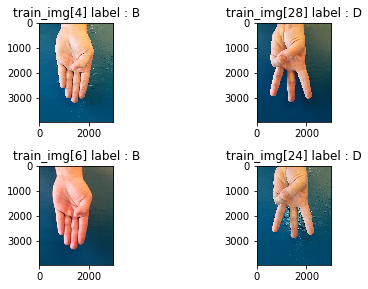

In [6]:
# let's take a look at some of the images (train)

# randomly pick 4 of the images
samp = random.sample(range(0,len(train_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_img[' + str(samp[0]) + '] label : ' + str(train_label[samp[0]]))
plt.imshow(train_img[samp[0]].astype('uint8'))

plt.subplot(2,2,2)
plt.title('train_img[' + str(samp[1]) + '] label : ' + str(train_label[samp[1]]))
plt.imshow(train_img[samp[1]].astype('uint8'))

plt.subplot(2,2,3)
plt.title('train_img[' + str(samp[2]) + '] label : ' + str(train_label[samp[2]]))
plt.imshow(train_img[samp[2]].astype('uint8'))

plt.subplot(2,2,4)
plt.title('train_img[' + str(samp[3]) + '] label : ' + str(train_label[samp[3]]))
plt.imshow(train_img[samp[3]].astype('uint8'))

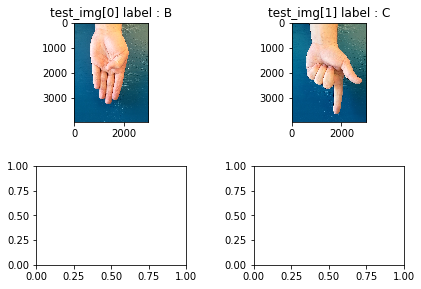

In [7]:
# let's take a look at some of the images (test)

# randomly pick 2 of the images
samp = random.sample(range(0,len(test_img)-1),2)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('test_img[' + str(samp[0]) + '] label : ' + str(test_label[samp[0]]))
plt.imshow(test_img[samp[0]].astype('uint8'))

plt.subplot(2,2,2)
plt.title('test_img[' + str(samp[1]) + '] label : ' + str(test_label[samp[1]]))
plt.imshow(test_img[samp[1]].astype('uint8'))

# Resize images
It doesn't matter which size the images are at the start, we'll try to scale them down here for the sake of efficiency

In [8]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# resize the images
basewidth = 64
img_list = []

# loop through all the images in the data and resize them
for img in train_img:
    # resize the numpy array images
    img = resize_images(img, basewidth)
    # add the image to a list of numpy array images
    img_list.append(img)

#print(img_list)
    
# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sun Feb 25 12:59:40 2018 

finish:  Sun Feb 25 13:00:10 2018 

this took --- 29.98 seconds ---


In [9]:
# convert the list with images back to a numpy array
train_img = np.array(img_list)
print(train_img.shape)

(36, 85, 64, 3)


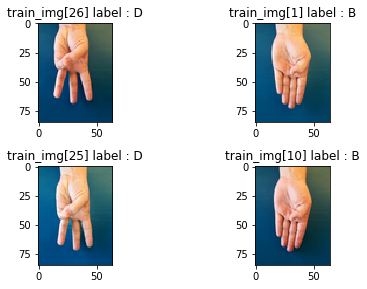

In [10]:
# let's take a look at some of the images (train)

# randomly pick 4 of the images
samp = random.sample(range(0,len(train_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_img[' + str(samp[0]) + '] label : ' + str(train_label[samp[0]]))
plt.imshow(train_img[samp[0]])

plt.subplot(2,2,2)
plt.title('train_img[' + str(samp[1]) + '] label : ' + str(train_label[samp[1]]))
plt.imshow(train_img[samp[1]])

plt.subplot(2,2,3)
plt.title('train_img[' + str(samp[2]) + '] label : ' + str(train_label[samp[2]]))
plt.imshow(train_img[samp[2]])

plt.subplot(2,2,4)
plt.title('train_img[' + str(samp[3]) + '] label : ' + str(train_label[samp[3]]))
plt.imshow(train_img[samp[3]])

In [11]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# resize the images
basewidth = 64
img_list = []

# loop through all the images in the data and resize them
for img in test_img:
    # resize the numpy array images
    img = resize_images(img, basewidth)
    # add the image to a list of numpy array images
    img_list.append(img)

#print(img_list)
    
# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sun Feb 25 13:00:13 2018 

finish:  Sun Feb 25 13:00:16 2018 

this took --- 2.6 seconds ---


In [12]:
# convert the list with images back to a numpy array
test_img = np.array(img_list)
print(test_img.shape)

(3, 85, 64, 3)


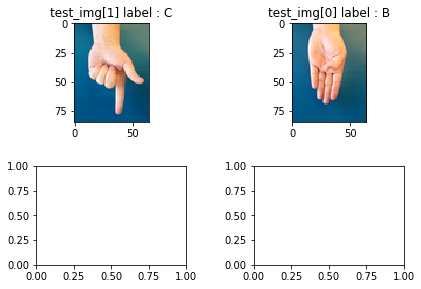

In [13]:
# let's take a look at some of the images (test)

# randomly pick 2 of the images
samp = random.sample(range(0,len(test_img)-1),2)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('test_img[' + str(samp[0]) + '] label : ' + str(test_label[samp[0]]))
plt.imshow(test_img[samp[0]])

plt.subplot(2,2,2)
plt.title('test_img[' + str(samp[1]) + '] label : ' + str(test_label[samp[1]]))
plt.imshow(test_img[samp[1]])

# Label matrix
The model needs a matrix where:
* the number of records = the number of images
* the number of columns = the number of possible values (labels) the images can represent

in this matrix all values will be 0 except for the column where the label is the label that specific image represents, there the value will be 1

In [14]:
# determine the number of unique labels
nr_possible_values = 40 #np.unique(train_label).size

# create a matrice with only zeros
# the number of rows = the number of images
# the number of columns = the number of possible values we want to recognize
label_matrix_train = np.zeros([train_label.shape[0], nr_possible_values])
label_matrix_test = np.zeros([test_label.shape[0], nr_possible_values])

# create a dictionary for the labels
# we're going to use this dictionary to determine which column in the matrix corresponds to which value
label_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9
              , 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19
              , 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'SPATIE': 26, 'PUNT': 27, 'STREEPJE': 28, '@': 29
              , '1': 30, '2': 31, '3': 32, '4': 33, '5': 34, '6': 35, '7': 36, '8': 37, '9': 38, '0': 39}

# set the value of 1 for each record in the column with the corresponding value
count = 0
for i in train_label:
    label_matrix_train[count, label_dict[i]] = 1
    count = count + 1

# set the value of 1 for each record in the column with the corresponding value
count = 0
for i in test_label:
    label_matrix_test[count, label_dict[i]] = 1
    count = count + 1

#print(label_matrix_train)
print(label_matrix_test)

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]


# Prepare the model
* define variables
* define funtions

In [15]:
# make sure to tell keras the channels are the last dimension in the shape of the dataset
# in this case the channel = 3, since we have full color images with 3 RGB channels
K.set_image_data_format('channels_last')


def plain_layer(X,n_c):
    X_in = X
    X = Conv2D(n_c,kernel_size = (3,3), padding = 'same')(X_in)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2,2))(X)
    return X


def identity_block(X,F):
    X_in = X
    
    F1,F2,F3 = F
    
    X = Conv2D(F1,kernel_size=(3,3),padding='same')(X_in)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_in = Conv2D(F3,kernel_size=(3,3),padding='same')(X_in)
    X_in = BatchNormalization(axis=3)(X_in)
    
    X = Add()([X,X_in])
    X = Activation('relu')(X)
    
    return X


def Resnet(input_shape = (85,64,3), classes = 6):
    X_in = Input(input_shape)
    
    X = plain_layer(X_in,32)
    
    F1 = [16,16,32]
    X = identity_block(X,F1)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    F2 = [16,16,32]
    X = identity_block(X,F2)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    F3 = [16,16,32]
    X = identity_block(X,F3)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    #X = plain_layer(X,32)
    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(512,activation='relu')(X)
    X = Dense(128,activation='relu')(X)
    X = Dense(classes,activation='softmax')(X)
    
    model = Model(inputs = X_in, outputs = X, name = 'Resnet')
    return model

# Train the model

In [22]:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

print("start: define data generator")
# define data preparation
datagen = image.ImageDataGenerator(rescale = 1/255 # normalize the data
                                   , rotation_range = 5 # degree range for random rotations
                                   , width_shift_range = 0.0 # range for random horizontal shifts
                                   , height_shift_range = 0.0 # range for random vertical shifts
                                   , shear_range = 0.1 # shear angle in counter-clockwise direction as radians
                                   , zoom_range = 0.05 # Range for random zoom
                                   , horizontal_flip = False # flip horizontally
                                   , vertical_flip = False # flip vertically
                                   , fill_mode = "nearest"
                                  )

print("start: fit parameters from data")
# fit parameters from data
datagen.fit(train_img)    

start: define data generator
start: fit parameters from data


In [23]:
# determine the shape of the images
img_shape = train_img.shape[1:4]

# declare a resnet model
my_model = Resnet(input_shape = img_shape, classes = nr_possible_values)

# print the current date and time
start = time.time()
print('start: ', str(time.ctime()), '\n')

# set the parameters for the model
my_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# define the training parameters
nr_ep = 200
btch_sz = 32
stps = 5 #int(len(train_img) / btch_sz)
print("the batch_size is " + str(btch_sz) + ", the number of steps_per_epoch is " + 
      str(stps) + " and the number of epochs is " + str(nr_ep) + '\n')

# train the model
# my_model.fit(x = train_img_norm, y = label_matrix_train, epochs = nr_ep, batch_size = btch_sz)

# train the model with the datagenerator images
my_model.fit_generator(datagen.flow(train_img, label_matrix_train, batch_size=btch_sz, save_to_dir='images', 
                                         save_prefix='aug', save_format='png', seed=1502),
                      steps_per_epoch = stps, epochs = nr_ep)

# print the current date and time
print('\n', 'finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

time.sleep(5)

start:  Sun Feb 25 13:16:11 2018 

the batch_size is 32, the number of steps_per_epoch is 5 and the number of epochs is 200

Epoch 1/200
5/5 [==============================] - 10s 2s/step - loss: 7.8338 - acc: 0.3235
Epoch 2/200
5/5 [==============================] - 7s 1s/step - loss: 10.1448 - acc: 0.3706
Epoch 3/200
5/5 [==============================] - 7s 1s/step - loss: 10.5129 - acc: 0.3478
Epoch 4/200
5/5 [==============================] - 6s 1s/step - loss: 11.3728 - acc: 0.2944
Epoch 5/200
5/5 [==============================] - 6s 1s/step - loss: 11.3728 - acc: 0.2944
Epoch 6/200
5/5 [==============================] - 7s 1s/step - loss: 11.6882 - acc: 0.2748
Epoch 7/200
5/5 [==============================] - 6s 1s/step - loss: 9.6099 - acc: 0.4038
Epoch 8/200
5/5 [==============================] - 7s 1s/step - loss: 11.1006 - acc: 0.3113
Epoch 9/200
5/5 [==============================] - 7s 1s/step - loss: 9.9253 - acc: 0.3842
Epoch 10/200
5/5 [==============================]

Epoch 88/200
5/5 [==============================] - 7s 1s/step - loss: 11.7980 - acc: 0.2680
Epoch 89/200
5/5 [==============================] - 7s 1s/step - loss: 11.3201 - acc: 0.2977
Epoch 90/200
5/5 [==============================] - 6s 1s/step - loss: 11.1342 - acc: 0.3092
Epoch 91/200
5/5 [==============================] - 7s 1s/step - loss: 10.4031 - acc: 0.3546
Epoch 92/200
5/5 [==============================] - 6s 1s/step - loss: 12.0797 - acc: 0.2505
Epoch 93/200
5/5 [==============================] - 8s 2s/step - loss: 10.6227 - acc: 0.3409
Epoch 94/200
5/5 [==============================] - 6s 1s/step - loss: 11.2535 - acc: 0.3018
Epoch 95/200
5/5 [==============================] - 7s 1s/step - loss: 11.2103 - acc: 0.3045
Epoch 96/200
5/5 [==============================] - 6s 1s/step - loss: 11.2535 - acc: 0.3018
Epoch 97/200
5/5 [==============================] - 5s 1s/step - loss: 13.2550 - acc: 0.1776
Epoch 98/200
5/5 [==============================] - 8s 2s/step - loss:

5/5 [==============================] - 8s 2s/step - loss: 10.9908 - acc: 0.3181
Epoch 176/200
5/5 [==============================] - 6s 1s/step - loss: 11.4921 - acc: 0.2870
Epoch 177/200
5/5 [==============================] - 6s 1s/step - loss: 10.0782 - acc: 0.3747
Epoch 178/200
5/5 [==============================] - 7s 1s/step - loss: 10.6227 - acc: 0.3409
Epoch 179/200
5/5 [==============================] - 7s 1s/step - loss: 9.9253 - acc: 0.3842
Epoch 180/200
5/5 [==============================] - 5s 1s/step - loss: 10.7852 - acc: 0.3309
Epoch 181/200
5/5 [==============================] - 5s 1s/step - loss: 12.5481 - acc: 0.2215
Epoch 182/200
5/5 [==============================] - 8s 2s/step - loss: 11.1006 - acc: 0.3113
Epoch 183/200
5/5 [==============================] - 8s 2s/step - loss: 10.6227 - acc: 0.3409
Epoch 184/200
5/5 [==============================] - 6s 1s/step - loss: 10.6659 - acc: 0.3383
Epoch 185/200
5/5 [==============================] - 6s 1s/step - loss: 11.

# Evaluate the model

In [24]:
# evaluate the model on the training data
eval_my_model = my_model.evaluate(train_img, label_matrix_train, batch_size = btch_sz)

print("The accuracy of this model is: " + str(round(eval_my_model[1]*100, 2)) + "%")

36/36 [==============================] - 1s 38ms/step
The accuracy of this model is: 33.33%


In [25]:
# evaluate the model on the test data
pred = my_model.predict(test_img)
pred_label = np.argmax(pred ,axis = 1)

# create an empty list for the labels
pred_label_translated = []

# translate the labels using the dictionary
for i in pred_label:
    pred_label_translated.append(list(label_dict.keys())[list(label_dict.values()).index(i)])

print(pred)
print(pred_label)
print(pred_label_translated)
print(test_label)

# create a classification report
print(classification_report(test_label, pred_label_translated))

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
[3 3 3]
['D', 'D', 'D']
['B' 'C' 'D']
             precision    recall  f1-score   support

          B       0.00      0.00      0.00         1
          C       0.00      0.00      0.00         1
          D       0.33      1.00      0.50         1

avg / total       0.11      0.33      0.17         3



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Save the model to disk
This way we can use the model on other computers

In [20]:
# location to save the model
imgloc = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/'

# serialize model to JSON and save it
my_model_json = my_model.to_json()
with open(imgloc + "my_model.json", "w") as json_file:
    json_file.write(my_model_json)

# serialize weights to HDF5
my_model.save_weights(imgloc + "my_model.h5")
print("Saved model to disk")

Saved model to disk
